<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/COVID_19_Forecast_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.adswerve.com"><img src="https://storage.googleapis.com/adswerve-oculi-public/adswerve.png"></a>
<h1>COVID-19 Impact Analysis using FB Prophet & GA Query Explorer</h1>

---



In [0]:
#@title 1. Import Libraries
#@markdown Click the <img src="https://storage.googleapis.com/adswerve-oculi-public/colab_play.png" width="22px" height="22px" /> button to run a cell, or click the cell then press "Shift + Enter"
from fbprophet import Prophet
import numpy as np
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from datetime import datetime, timedelta
results = pd.DataFrame()
plt.style.use('seaborn-white')

## Instructions:



### Copy / Paste your `API Query URI` from GA Query Explorer Tool
Follow first 4-steps detailed here:  
https://reflectivedata.com/working-with-google-analytics-data-using-python-and-jupyter-notebooks  

Or follow this general guidance:  

*   Navigate to GA Query Explorer: https://ga-dev-tools.appspot.com/query-explorer/  <br>  

*   Select Account / Property / View <br> <img src="https://storage.googleapis.com/adswerve-oculi-public/as_select_view.png"> <br>  

*   Select metric, ie. `ga:goal3Completions` and add `ga:date` as dimension; set start-date to `1000daysAgo` (row limit)<br> <img src="https://storage.googleapis.com/adswerve-oculi-public/as_select_parameters.png?"><br>  

*   Run query then fetch API Query URI after checking "Include current `access_token`"<br><img src="https://storage.googleapis.com/adswerve-oculi-public/as_api_query.png">

## Analysis Routine:

In [10]:
#@title 2. Execute API Query URI from GA Query Explorer
#@markdown NOTE: If this cell throws an error, try refreshing your query
metric_name = "Goal 3 Completions" #@param {type:"string"}

from getpass import getpass 
api_query_uri = getpass('Enter API Query URI here') 
r = requests.get(api_query_uri) 
data= r.json() 
df = pd.DataFrame(data['rows']) 
df = df.rename(columns={0: 'Date', 1: metric_name}) 
df[metric_name] = df[metric_name].astype(float) 
df['Date'] = pd.to_datetime(df['Date'])
df = df.replace(0, np.nan).dropna().reset_index(drop=True)
df.head()

Enter API Query URI here··········


,Date,Goal 3 Completions
0,2018-07-12,8.0
1,2018-07-13,3.0
2,2018-07-14,2.0
3,2018-07-16,9.0
4,2018-07-17,15.0


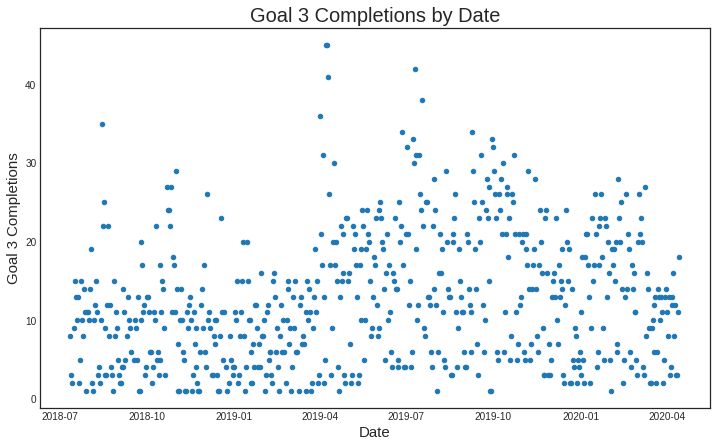

In [11]:
#@title 3. Plot Results
_ = df.plot.scatter( x='Date', y=metric_name, figsize=[12, 7])
plt.xlabel('Date',size = 15)
plt.ylabel(metric_name, size = 15)
plt.title(f'{metric_name} by Date', size=20)
plt.show()

In [0]:
#@title 4. Define Holidays & Events
#@markdown Double-click **HERE** to edit cell.<br/>Copy/Paste or edit the `holidays.append()` statements to meet your specfic business needs. 

holidays = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25', '2020-12-25']),
  'lower_window': -7,
  'upper_window': 3,
})

holidays = holidays.append(pd.DataFrame({
  'holiday': 'Black Friday',
  'ds': pd.to_datetime(['2016-11-25', '2017-11-24', '2018-11-23', '2019-11-29', '2020-11-27']),
  'lower_window': 0,
  'upper_window': 0,
}))

holidays = holidays.append(pd.DataFrame({
  'holiday': 'Cyber Monday',
  'ds': pd.to_datetime(['2016-11-28', '2017-11-27', '2018-11-26', '2019-12-02', '2020-11-30']),
  'lower_window': 0,
  'upper_window': 0,
}))

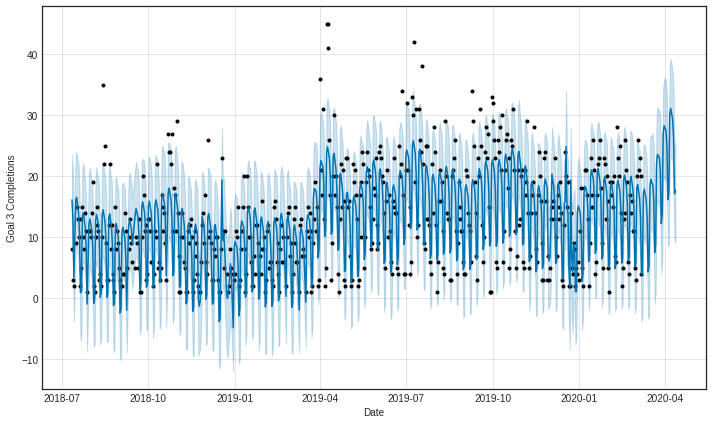

In [13]:
#@title 5. Generate Model
COVID_start_date = "2020-03-08" #@param {type:"date"}
start = datetime.strptime(COVID_start_date, "%Y-%m-%d") 
post_lag_back = start - timedelta(days=7) 
year_back = start - timedelta(days=365)
m = Prophet(holidays=holidays, interval_width=0.85, mcmc_samples=25, yearly_seasonality=True)
input_df = df.loc[df['Date'] < COVID_start_date].rename(columns={'Date': 'ds', metric_name: 'y'})
# train model using input dataframe
m.fit(input_df)

# Build dataframe with 36 day forecast
f = m.make_future_dataframe(36)

# generate forecast using predict()
forecast = m.predict(f)
clear_output()
# plot the forecast data
_ = m.plot(forecast,xlabel='Date', ylabel=metric_name)

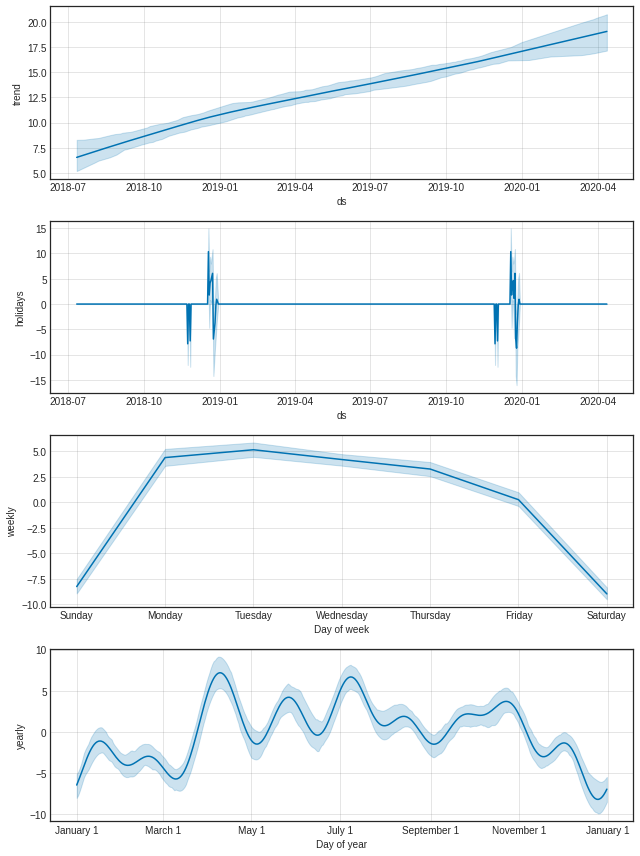

In [14]:
#@title 6. Inspect Seasonal Models
_ = m.plot_components(forecast,)

## Inspect Results

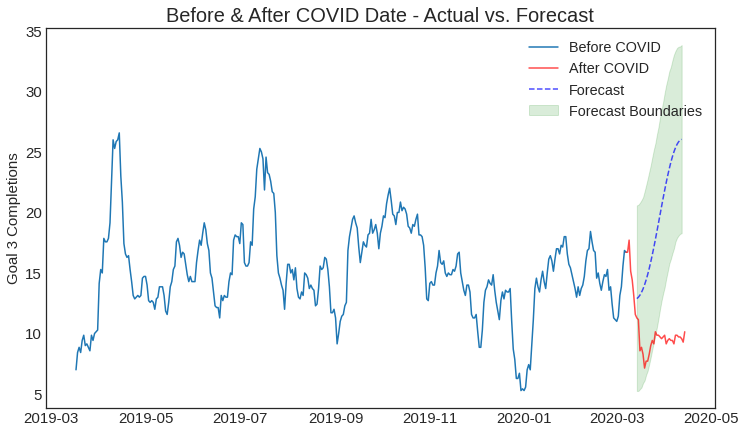

In [15]:
#@title 7. Analysis: Actual vs Forecast
post_event = df.loc[df['Date']  >= post_lag_back].rename(columns={'Date': 'ds', metric_name: 'y'})
filter_forecast = forecast.loc[forecast['ds']  >= COVID_start_date]
filter_input_df = input_df.loc[forecast['ds']  >= year_back]

plt.figure(figsize=(12,7))
plt.axes()

plt.plot('ds', 'y', '-', label='Before COVID', data=filter_input_df.set_index('ds').rolling(7).mean().reset_index())
plt.plot('ds', 'y','-r', label='After COVID', data=post_event.set_index('ds').rolling(7).mean().reset_index(), alpha=.7)
plt.plot('ds', 'yhat', '--b', label='Forecast', alpha=.7, data=filter_forecast.set_index('ds').rolling(7).mean().reset_index())

# plot the Prophet model forecast boundaries
rollavg_filterforecast = filter_forecast.set_index('ds').rolling(7).mean().reset_index()
plt.fill_between(rollavg_filterforecast.ds, rollavg_filterforecast.yhat_lower, rollavg_filterforecast.yhat_upper,color='g', alpha=0.15, label='Forecast Boundaries')

plt.ylabel(metric_name, size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(
    fontsize='x-large',
    #loc='upper left'
    )
plt.title('Before & After COVID Date - Actual vs. Forecast', size=20)
plt.show()

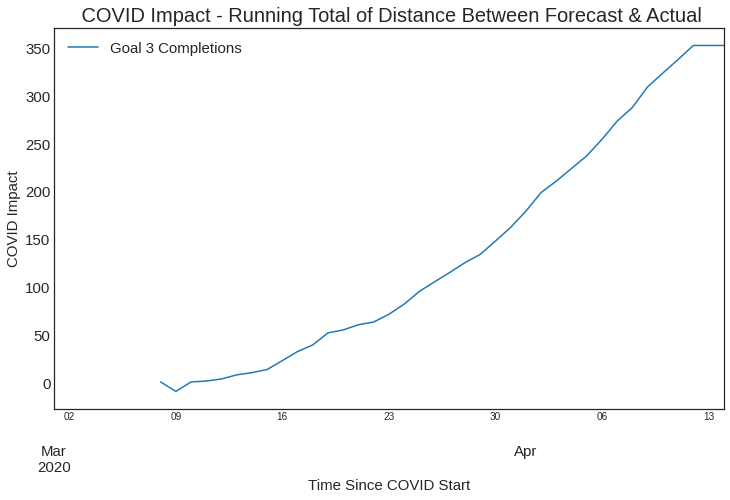

In [17]:
#@title 8. Running Sum of Distance Between Forecast  & Actual

combined = filter_forecast[['ds','yhat']].merge(post_event, on='ds', how='outer')
combined[metric_name] = combined['yhat'] - combined['y']
combined = combined.set_index(combined.ds).drop('ds',axis=1)

l = datetime.today() - post_lag_back
index = pd.date_range(post_lag_back, periods=l.days, freq='D') 
paddf = pd.DataFrame(index=index).dropna()
pad_combined = paddf.merge(combined, how='outer',left_index=True,right_index=True)
results[metric_name] = pad_combined[metric_name]
for c in results.columns:
  results[c].cumsum().interpolate().plot(figsize=(12,7))
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Time Since COVID Start", size=15)
plt.ylabel("COVID Impact", size=15)
plt.legend(fontsize=15)
plt.title(" COVID Impact - Running Total of Distance Between Forecast & Actual", size=20)
plt.show()